<a href="https://colab.research.google.com/github/passionate-code/ml_dl_playground/blob/main/sequences_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
#!ls /content/gdrive/MyDrive

Mounted at /content/gdrive


In [ ]:
! apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
! git clone

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

df = pd.read_csv('/content/gdrive/MyDrive/labels.csv',header=None,names=["header1"])
df['Seq'] = pd.read_csv('/content/gdrive/MyDrive/sequences.csv')
df.rename(columns = {'header1':'Label'}, inplace = True)
df.head()

,Label,Seq
0,1,GATTTAAGTGAATAGCTTGGCTATCTCACTTTCCCTCGTTCTCTTG
1,1,GATTTAAGTGAATAGCTTGGCTATCTCACTTTCCCTCGTTCTCTTG
2,1,GATTTAAGTGAATAGCTTGGCTATCTCACTTCCCCTCGTTCTCTTG
3,1,GATTTAAGTGAATAGCTTGGCTATCTCACTTCCCCTCGTTCTCTTG
4,2,GTGAGCGATTTGCGTGCGTGCATCCCGCTTCACTGATCTCTTGTTA


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5 non-null      int64 
 1   Seq     5 non-null      object
dtypes: int64(1), object(1)
memory usage: 208.0+ bytes


In [ ]:
print('Total records:', df['Label'].count())
df.groupby(['Label']).count()

Total records: 5


,Seq
Label,
1,4
2,1


In [ ]:
def subBases(seq):
    dict_seq = {'N': 0.0, 'C': 0.25, 'T': 0.5, 'G': 0.75, 'A': 1.0,}
    lst_seq = []
    for bs in list(seq):
        if bs != 'N' and bs != 'C' and bs != 'T' and bs != 'G' and bs != 'A':
            lst_seq.append(dict_seq['N'])
        else:
            lst_seq.append(dict_seq[bs])

    # Padded for equal length of input
    if len(lst_seq) < 31029:
        pad_length = 31029 - len(lst_seq)
        lst_seq.extend([0.0 for i in range(pad_length)])

    # Return list of floats
    return lst_seq

lst_encoded = []
seq = df['Seq']
for row in seq:
    lst_encoded.append(subBases(row))

In [ ]:
df_dummy = pd.DataFrame(lst_encoded)
df_dummy['Label'] = df['Label']
df_dummy.head()


,0,1,2,3,4,5,6,7,8,9,...,31020,31021,31022,31023,31024,31025,31026,31027,31028,Label
0,0.75,1.0,0.50,0.5,0.50,1.00,1.00,0.75,0.5,0.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.75,1.0,0.50,0.5,0.50,1.00,1.00,0.75,0.5,0.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.75,1.0,0.50,0.5,0.50,1.00,1.00,0.75,0.5,0.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.75,1.0,0.50,0.5,0.50,1.00,1.00,0.75,0.5,0.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.75,0.5,0.75,1.0,0.75,0.25,0.75,1.00,0.5,0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [ ]:
# Let's split the data into training and validation set and random_state is random seed for result reproduce purpose:
val_df = df_dummy.sample(frac = 0.2, random_state = 1337)
train_df = df_dummy.drop(val_df.index)

print('Using %d samples for training and %d for validation' \
      % (len(train_df), len(val_df)))

Using 4 samples for training and 1 for validation


In [ ]:
cols = df_dummy.columns

# convert training and validation set to tf.Tensor
train_cols = train_df[cols]
y_train = train_cols.pop('Label')
val_cols = val_df[cols]
y_val = val_cols.pop('Label')

# convert pandas series into tensor
train_ds = tf.convert_to_tensor(train_cols)#train features encoded
y_train_ds = tf.convert_to_tensor(y_train)#train labels
val_ds = tf.convert_to_tensor(val_cols)
y_val_ds = tf.convert_to_tensor(y_val)

print(train_ds.shape)
print(y_train_ds.shape)
print(val_ds.shape)
print(y_val_ds.shape)


(4, 31029)
(4,)
(1, 31029)
(1,)


In [ ]:
# Reformating the tensor shape
x_train = tf.reshape(train_ds, [-1, 1, 31029, 1])
x_val = tf.reshape(val_ds, [-1, 1, 31029, 1])

y_train = tf.reshape(y_train_ds, [4, ])
y_val = tf.reshape(y_val_ds, [1, ])

In [ ]:
x_train = tf.transpose(x_train, perm=[0, 3, 2, 1])
x_val = tf.transpose(x_val, perm=[0, 3, 2, 1])

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(12, (1, 1), activation='relu', padding='same', input_shape=(1, 31029, 1))) #2D images e.g. sequences as heatmap used CNN layer 12 filters (set of kernels that define output channel) 1 by 1 matrix kernel, activation func RELU
model.add(layers.MaxPool2D(148, (1, 148), padding='same'))
model.add(layers.Flatten()) # flatten input tensor. in this case 3D > 1D. After CNN layer and Maxpool and before FNN
model.add(layers.Dense(196)) # set up fully connected layers with 196 neurons
model.add(layers.Dropout(0.5)) # reduce overfitting where dropout layer randomly sets a fraction of input units to zero at each update during training time
model.add(layers.Dense(5)) # set up fully connected layers with 5 neurons

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 1, 31029, 12)      24        
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 210, 12)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2520)              0         
                                                                 
 dense_2 (Dense)             (None, 196)               494116    
                                                                 
 dropout_1 (Dropout)         (None, 196)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 985       
                                                      

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #multiclass problem used this
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=50, \
                    validation_data=(x_val, y_val), batch_size=None)

Epoch 1/50
1/1 [==============================] - 1s 789ms/step - loss: 1.5798 - accuracy: 0.2500 - val_loss: 1.5651 - val_accuracy: 1.0000
Epoch 2/50
1/1 [==============================] - 0s 44ms/step - loss: 1.5766 - accuracy: 0.5000 - val_loss: 1.5255 - val_accuracy: 1.0000
Epoch 3/50
1/1 [==============================] - 0s 41ms/step - loss: 1.5407 - accuracy: 0.7500 - val_loss: 1.4796 - val_accuracy: 1.0000
Epoch 4/50
1/1 [==============================] - 0s 39ms/step - loss: 1.5074 - accuracy: 0.7500 - val_loss: 1.4248 - val_accuracy: 1.0000
Epoch 5/50
1/1 [==============================] - 0s 40ms/step - loss: 1.4650 - accuracy: 0.7500 - val_loss: 1.3605 - val_accuracy: 1.0000
Epoch 6/50
1/1 [==============================] - 0s 38ms/step - loss: 1.4182 - accuracy: 0.7500 - val_loss: 1.2871 - val_accuracy: 1.0000
Epoch 7/50
1/1 [==============================] - 0s 43ms/step - loss: 1.3766 - accuracy: 0.7500 - val_loss: 1.2044 - val_accuracy: 1.0000
Epoch 8/50
1/1 [==========

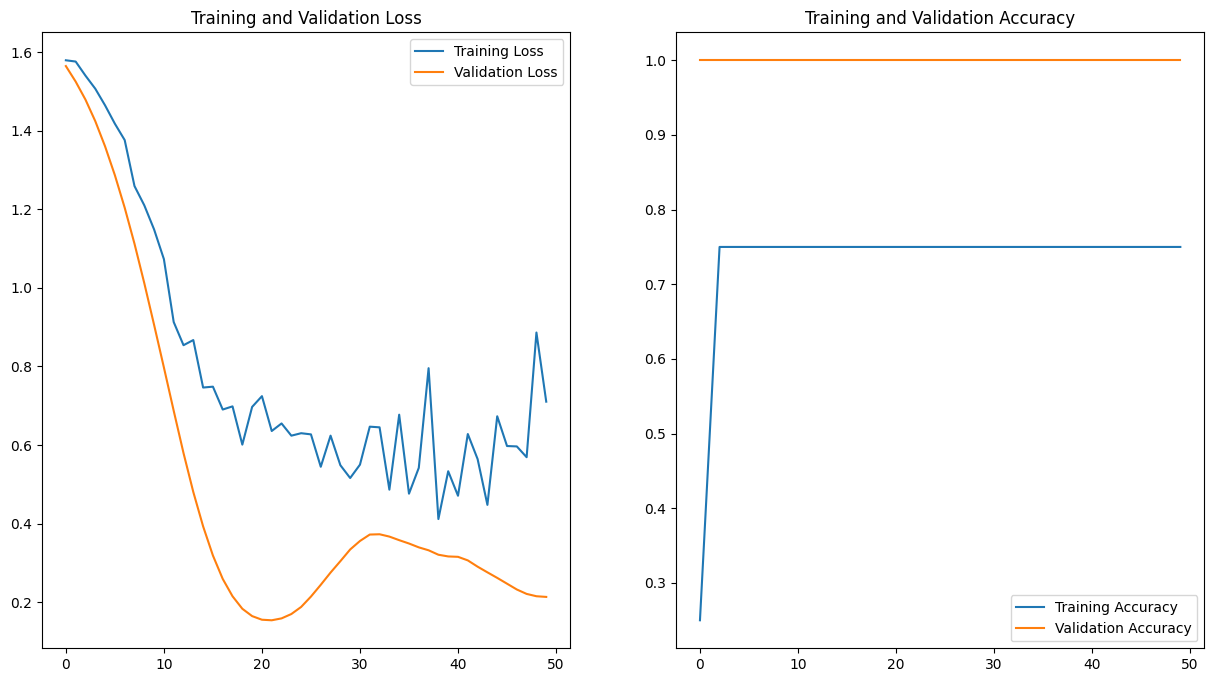

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15, 8)) #sets the width to 15 inches and the height to 8 inches
plt.subplot(1, 2, 2) #create a subplot grid that has 1 row and 2 columns and the plot you're defining will be the first plot in this grid.
plt.plot(epochs_range, acc, label='Training Accuracy')#render plot
plt.plot(epochs_range, val_acc, label='Validation Accuracy')#render plot
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()